# Collecting experiments data in a data frame

### Bogumił Kamiński

In [1]:
using DataFrames

In [2]:
using Statistics

In [3]:
using PyPlot

<div class="alert alert-block alert-info">
    <p><b>PyPlot.jl configuration:</b></p>
    <p>In some environments automatic installation of PyPlot.jl might fail. If you encounter this ussue please refer to <a href="https://github.com/JuliaPy/PyPlot.jl#installation">the PyPlot.jl installation instructions</a>. </p>
</div>

In particular typically executing the following commands:

```
ENV["PYTHON"]=""
Pkg.build("PyCall")
```

should resolve the PyPlot.jl installation issues. However, on OS X sometimes more configuration steps are required. You can find the detailed instructions [here](https://github.com/JuliaPy/PyPlot.jl#os-x).

In [4]:
using Random

In [5]:
using Pipe

In this part we will run a simple Monte Carlo simulation so show examples how one can work with data frames.

Consider the following puzzle.

We draw independent random numbers from $U(0,1)$ distribution. On the average, how many draws do we need, till the sum of these numbers exceeds $1$?

Here is the code that runs this experiment once. For tutorial reasons we keep all the generated random numbers and recalculate their sum in each iteration (you can try to improve the efficiency of this code as an exercise).

In [6]:
function sim_e()
    draw = Float64[]
    while true
        push!(draw, rand())
        sum(draw) > 1.0 && return draw
    end
end

sim_e (generic function with 1 method)

In [7]:
Random.seed!(1234); # just to make sure we get the same results if we are on the same version of Julia

Let us run our simulation several times:

In [8]:
res = [sim_e() for _ in 1:5]

5-element Vector{Vector{Float64}}:
 [0.5908446386657102, 0.7667970365022592]
 [0.5662374165061859, 0.4600853424625171]
 [0.7940257103317943, 0.8541465903790502]
 [0.20058603493384108, 0.2986142783434118, 0.24683718661000897, 0.5796722333690416]
 [0.6488819502093455, 0.010905889635595356, 0.06642303695533736, 0.9567533636029237]

and check that each time we finished just when we exceeded $1$:

In [9]:
sum.(res)

5-element Vector{Float64}:
 1.3576416751679694
 1.026322758968703
 1.6481723007108444
 1.3257097332563035
 1.682964240403202

In [10]:
@. sum(res) - last(res)

5-element Vector{Float64}:
 0.5908446386657102
 0.5662374165061859
 0.7940257103317943
 0.7460374998872619
 0.7262108768002782

All looks good so far! (and as a bonus we have just made a small exercise in broadcasting)

Now let us populate a data frame with the results of our experiments

In [11]:
df = DataFrame()

@time for i in 1:10^7
    push!(df, (id=i, pos=sim_e()))
end

 11.808337 seconds (151.98 M allocations: 4.933 GiB, 33.30% gc time, 5.65% compilation time)


As you can see the process was quite fast, `push!`-ing data to a `DataFrame` is efficient.

In [12]:
df

,id,pos
,Int64,Array…
1,1,"[0.646691, 0.112486, 0.276021]"
2,2,"[0.651664, 0.0566425, 0.842714]"
3,3,"[0.950498, 0.96467]"
4,4,"[0.945775, 0.789904]"
5,5,"[0.82116, 0.0341601, 0.0945445, 0.314926]"
6,6,"[0.12781, 0.374187, 0.931115]"
7,7,"[0.438939, 0.246862, 0.0118196, 0.0460428, 0.496169]"
8,8,"[0.732, 0.299058]"
9,9,"[0.449182, 0.875096]"


Let us count the number of jumps we have made in each step using the `transform!` function:

In [13]:
transform!(df, :pos => ByRow(length) => :jumps)

,id,pos,jumps
,Int64,Array…,Int64
1,1,"[0.646691, 0.112486, 0.276021]",3
2,2,"[0.651664, 0.0566425, 0.842714]",3
3,3,"[0.950498, 0.96467]",2
4,4,"[0.945775, 0.789904]",2
5,5,"[0.82116, 0.0341601, 0.0945445, 0.314926]",4
6,6,"[0.12781, 0.374187, 0.931115]",3
7,7,"[0.438939, 0.246862, 0.0118196, 0.0460428, 0.496169]",5
8,8,"[0.732, 0.299058]",2
9,9,"[0.449182, 0.875096]",2


Let us dissect what we have written above:
* `transform!` adds columns to a data frame in-place
* `:pos` is a source column
* `ByRow(length)` tells us that we want to apply `length` function to each element for `:pos` column (without it `length` would be applied to the whole column - can you guess what would be the result?)
* `:jumps` is the name of the column that should be created

Now we are ready to find the average number of jumps that are made:

In [14]:
mean(df.jumps)

2.7185991

or

In [15]:
combine(df, :jumps => mean)

,jumps_mean
,Float64
1,2.7186


which happens to be very close to:

In [16]:
MathConstants.e

ℯ = 2.7182818284590...

Let us now find a distribution of number of jumps:

In [17]:
jumps_agg = @pipe df |>
                  groupby(_, :jumps, sort=true) |>
                  combine(_, :jumps => length)

,jumps,jumps_length
,Int64,Int64
1,2,4999743
2,3,3332539
3,4,1250009
4,5,333738
5,6,69865
6,7,12145
7,8,1725
8,9,204
9,10,31


and normalize it as a fraction (and at the same time calculate some theoretical result that we have *guessed* :)):

In [18]:
transform!(jumps_agg,
           :jumps_length => (x -> x ./ sum(x)) => :simulation,
           :jumps => ByRow(x -> (x-1) / factorial(x)) => :theory)

,jumps,jumps_length,simulation,theory
,Int64,Int64,Float64,Float64
1,2,4999743,0.499974,0.5
2,3,3332539,0.333254,0.333333
3,4,1250009,0.125001,0.125
4,5,333738,0.0333738,0.0333333
5,6,69865,0.0069865,0.00694444
6,7,12145,0.0012145,0.00119048
7,8,1725,0.0001725,0.000173611
8,9,204,2.04e-5,2.20459e-5
9,10,31,3.1e-6,2.48016e-6


Let us briefly justify how we have guessed it (you can safely skip the derivation):

Formula
$$
p_n = \frac{n-1}{n!}
$$

$$
\sum_{n=2}^{+\infty}p_n=\sum_{n=2}^{+\infty} \frac{n-1}{n!} = \sum_{n=1}^{+\infty} \frac{1}{n!} - \sum_{n=2}^{+\infty} \frac{1}{n!} = 1
$$

$$
\sum_{n=2}^{+\infty}n\cdot p_n=\sum_{n=2}^{+\infty} n\frac{n-1}{n!} = \sum_{n=2}^{+\infty} \frac{1}{(n-2)!} = e
$$

Now we note that:

$$
1-\sum_{n=2}^k p_n = \frac{1}{k!}
$$
which can be most easily justified by a geometric argument.

To finish this section of the tutorial let us check if random numbers generated using `rand()` were indeed $U(0,1)$.

To do this we will add some columns to `df` data frame.

In [19]:
df

,id,pos,jumps
,Int64,Array…,Int64
1,1,"[0.646691, 0.112486, 0.276021]",3
2,2,"[0.651664, 0.0566425, 0.842714]",3
3,3,"[0.950498, 0.96467]",2
4,4,"[0.945775, 0.789904]",2
5,5,"[0.82116, 0.0341601, 0.0945445, 0.314926]",4
6,6,"[0.12781, 0.374187, 0.931115]",3
7,7,"[0.438939, 0.246862, 0.0118196, 0.0460428, 0.496169]",5
8,8,"[0.732, 0.299058]",2
9,9,"[0.449182, 0.875096]",2


In [20]:
df_test = select(df, :pos => ByRow(first) => :first, :pos => ByRow(last) => :last)

,first,last
,Float64,Float64
1,0.646691,0.276021
2,0.651664,0.842714
3,0.950498,0.96467
4,0.945775,0.789904
5,0.82116,0.314926
6,0.12781,0.931115
7,0.438939,0.496169
8,0.732,0.299058
9,0.449182,0.875096


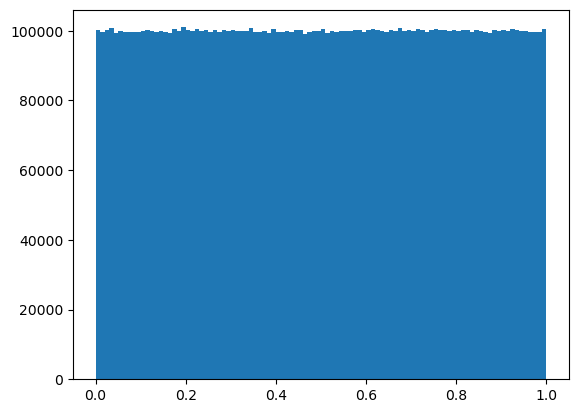

In [21]:
hist(df_test.first, 100);

So far all looks good. But let us look at the distribution of the last dawn random number:

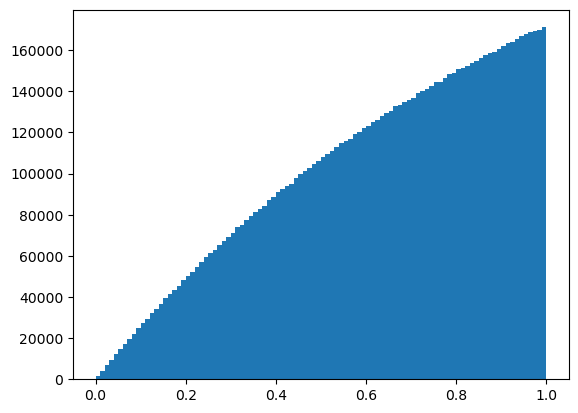

In [22]:
hist(df_test.last, 100);

So - is the `rand()` function broken for the last generated random number in each sequence or something else has made the distribution stop being uniform?